#### Import Necessary Libraries

In [363]:
import copy
from tqdm import tqdm
from datetime import timedelta

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt

### Load Data

In [398]:
DATE = '09-02-2025-NOON'
CRYPTO_PAIRS = ['BTCUSDT', 'ETHUSDT']
TICK_SIZES = { crypto_pair: 1e-2 for crypto_pair in CRYPTO_PAIRS }
LOT_SIZES = { 'BTCUSDT': 1e-5, 'ETHUSDT': 1e-4 }
ODB_DEPTH = 10

In [406]:
# load data csv
data = {
    'DEPTH': { crypto_pair: pd.read_csv(f"../data/{DATE}/BINANCE-{crypto_pair}-DEPTH.csv") for crypto_pair in tqdm(CRYPTO_PAIRS) },
    'TRADE': { crypto_pair: pd.read_csv(f"../data/{DATE}/BINANCE-{crypto_pair}-TRADES.csv") for crypto_pair in tqdm(CRYPTO_PAIRS) }
}

# convert time column to datetime timestamps and then move it to index
for crypto_pair in CRYPTO_PAIRS:

    # remove the unecessary columns
    data['DEPTH'][crypto_pair].drop('timestamp', axis=1, inplace=True)
    data['TRADE'][crypto_pair].drop(['timestamp', 'E'], axis=1, inplace=True)

    data['DEPTH'][crypto_pair].E = pd.to_datetime(data['DEPTH'][crypto_pair].loc[:, 'E'], unit='ms')
    data['TRADE'][crypto_pair].T = pd.to_datetime(data['TRADE'][crypto_pair].loc[:, 'T'], unit='ms')

    data['DEPTH'][crypto_pair].set_index('E', inplace=True)
    data['TRADE'][crypto_pair].set_index('T', inplace=True)

    # sort index to prevent any discrepency
    # kind='mergesort' is important as we want the original order intact in case of ties
    data['DEPTH'][crypto_pair].sort_index(kind='mergesort', inplace=True)
    data['TRADE'][crypto_pair].sort_index(kind='mergesort', inplace=True)

    data['DEPTH'][crypto_pair].index.name = 'timestamp'
    data['TRADE'][crypto_pair].index.name = 'timestamp'

100%|██████████| 2/2 [00:02<00:00,  1.22s/it]


In [407]:
data['DEPTH']['BTCUSDT']

,bp1,bp2,bp3,bp4,bp5,bp6,bp7,bp8,bp9,bp10,bv1,bv2,bv3,bv4,bv5,bv6,bv7,bv8,bv9,bv10,ap1,ap2,ap3,ap4,ap5,ap6,ap7,ap8,ap9,ap10,av1,av2,av3,av4,av5,av6,av7,av8,av9,av10
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1970-01-01 00:00:00.000,96989.99,96989.98,96989.97,96989.96,96989.91,96989.90,96989.81,96989.80,96989.79,96989.78,10.69103,0.00018,0.00018,0.00018,0.00030,0.05862,0.00030,0.73024,0.00012,0.00012,96990.00,96990.30,96990.43,96990.46,96990.47,96990.66,96990.76,96990.84,96991.33,96991.34,20.50288,0.00029,0.00018,0.00030,0.00018,0.00018,0.00018,0.00018,0.00024,0.01057
2025-02-09 07:12:01.814,96989.99,96989.98,96989.97,96989.96,96989.91,96989.90,96989.81,96989.80,96989.79,96989.78,11.48073,0.00018,0.00018,0.00018,0.00030,0.05862,0.00030,0.73024,0.00012,0.00012,96990.00,96990.30,96990.43,96990.46,96990.47,96990.66,96990.76,96990.84,96991.33,96991.34,20.50288,0.00029,0.00018,0.00030,0.00018,0.00018,0.00018,0.00018,0.00024,0.01057
2025-02-09 07:12:01.914,96989.99,96989.98,96989.97,96989.96,96989.91,96989.90,96989.81,96989.80,96989.79,96989.78,11.48073,0.00018,0.00018,0.00018,0.00030,0.05862,0.00030,0.73024,0.00012,0.00012,96990.00,96990.30,96990.43,96990.46,96990.47,96990.66,96990.76,96990.84,96991.33,96991.34,20.50288,0.00029,0.00018,0.00030,0.00018,0.00018,0.00018,0.00018,0.00024,0.01057
2025-02-09 07:12:02.014,96989.99,96989.98,96989.97,96989.96,96989.91,96989.90,96989.81,96989.80,96989.79,96989.78,11.48073,0.00018,0.00018,0.00018,0.00030,0.05862,0.00030,0.73024,0.00012,0.00012,96990.00,96990.30,96990.43,96990.46,96990.47,96990.66,96990.76,96990.84,96991.33,96991.34,20.50288,0.00029,0.00018,0.00030,0.00018,0.00018,0.00018,0.00018,0.00024,0.01057
2025-02-09 07:12:02.114,96989.99,96989.98,96989.97,96989.96,96989.91,96989.90,96989.81,96989.80,96989.79,96989.78,11.47977,0.00018,0.00018,0.00018,0.00030,0.05862,0.00030,0.73024,0.00012,0.00012,96990.00,96990.30,96990.43,96990.46,96990.47,96990.66,96990.76,96990.84,96991.33,96991.34,20.48261,0.00029,0.00018,0.00030,0.00018,0.00018,0.00018,0.00018,0.00024,0.01057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-10 01:29:51.014,96200.00,96199.93,96199.28,96199.22,96198.76,96198.75,96198.60,96198.21,96198.01,96198.00,10.35129,0.00037,0.00029,0.00025,0.00018,0.00018,0.00018,0.00029,0.00024,0.07152,96200.01,96200.35,96200.36,96200.37,96200.38,96200.56,96200.79,96201.12,96201.15,96201.53,6.21713,0.00018,0.24375,0.07359,0.00006,0.00006,0.00013,0.00772,0.06144,0.00006
2025-02-10 01:29:51.114,96200.00,96199.93,96199.28,96199.22,96198.76,96198.75,96198.60,96198.21,96198.01,96198.00,10.35129,0.00037,0.00029,0.00025,0.00018,0.00018,0.00018,0.00029,0.00024,0.07152,96200.01,96200.35,96200.36,96200.37,96200.38,96200.56,96200.79,96201.12,96201.15,96201.53,6.21720,0.00018,0.24375,0.07359,0.00006,0.00006,0.00013,0.00772,0.06144,0.00006
2025-02-10 01:29:51.214,96200.00,96199.93,96199.28,96199.22,96198.76,96198.75,96198.60,96198.21,96198.01,96198.00,10.35129,0.00037,0.00029,0.00025,0.00018,0.00018,0.00018,0.00029,0.00024,0.07152,96200.01,96200.35,96200.36,96200.37,96200.38,96200.56,96200.79,96201.12,96201.15,96201.53,6.21720,0.00018,0.24375,0.07359,0.00006,0.00006,0.00013,0.00761,0.06084,0.00006


In [408]:
data['TRADE']['BTCUSDT']

,p,q,mm_buy
timestamp,,,
2025-02-09 07:12:01.423,96990.00,0.00689,0
2025-02-09 07:12:01.502,96990.00,0.00013,0
2025-02-09 07:12:01.544,96990.00,0.00102,0
2025-02-09 07:12:01.544,96990.00,0.00009,0
2025-02-09 07:12:01.544,96990.00,0.00306,0
...,...,...,...
2025-02-10 01:30:33.416,96212.19,0.00006,0
2025-02-10 01:30:33.416,96212.19,0.00006,0
2025-02-10 01:30:33.577,96212.19,0.00233,1


In [409]:
for crypto_pair in tqdm(CRYPTO_PAIRS):
    # the first row requires syncing orderbook so the timestamp in it is `0` which is not valid. So, we simply drop it.
    data['DEPTH'][crypto_pair].drop(data['DEPTH'][crypto_pair].index[:1], inplace=True)
    # only keep the trades that happen between the first and last timestamp in the depth dataframe
    data['TRADE'][crypto_pair] = data['TRADE'][crypto_pair][np.logical_and(data['TRADE'][crypto_pair].index >= data['DEPTH'][crypto_pair].index[0], data['TRADE'][crypto_pair].index <= data['DEPTH'][crypto_pair].index[-1])]

100%|██████████| 2/2 [00:00<00:00,  7.48it/s]


In [410]:
data['TRADE']['BTCUSDT']

,p,q,mm_buy
timestamp,,,
2025-02-09 07:12:02.067,96990.00,0.00015,0
2025-02-09 07:12:02.069,96990.00,0.02000,0
2025-02-09 07:12:02.071,96989.99,0.00096,1
2025-02-09 07:12:02.464,96990.00,0.01374,0
2025-02-09 07:12:03.252,96990.00,0.00289,0
...,...,...,...
2025-02-10 01:29:48.730,96200.01,0.01642,0
2025-02-10 01:29:49.639,96200.00,0.00029,1
2025-02-10 01:29:49.970,96200.01,0.00006,0


In [411]:
# No big gaps hence the integrity of the data upholds
for crypto_pair in CRYPTO_PAIRS:
    print(pd.Series(data['DEPTH'][crypto_pair].index).diff()[pd.Series(data['DEPTH'][crypto_pair].index).diff() > timedelta(milliseconds=400)])
# orderbook snapshots come on an average with a delay of 100ms and we are good.
# trades on the otherhand are real-time and can have occassional large gaps.

Series([], Name: timestamp, dtype: timedelta64[ns])
Series([], Name: timestamp, dtype: timedelta64[ns])


### Preprocess Data

In [412]:
# convert all the data from floating point to integers to make easier queue related calculations
for crypto_pair in tqdm(CRYPTO_PAIRS):
    data['DEPTH'][crypto_pair].loc[:, [f'bp{i}' for i in range(1, ODB_DEPTH+1)] + [f'ap{i}' for i in range(1, ODB_DEPTH+1)]] = data['DEPTH'][crypto_pair].loc[:, [f'bp{i}' for i in range(1, ODB_DEPTH+1)] + [f'ap{i}' for i in range(1, ODB_DEPTH+1)]] / TICK_SIZES[crypto_pair]
    data['DEPTH'][crypto_pair].loc[:, [f'bv{i}' for i in range(1, ODB_DEPTH+1)] + [f'av{i}' for i in range(1, ODB_DEPTH+1)]] = data['DEPTH'][crypto_pair].loc[:, [f'bv{i}' for i in range(1, ODB_DEPTH+1)] + [f'av{i}' for i in range(1, ODB_DEPTH+1)]] / LOT_SIZES[crypto_pair]
    data['TRADE'][crypto_pair].loc[:, 'p'] = data['TRADE'][crypto_pair].p / TICK_SIZES[crypto_pair]
    data['TRADE'][crypto_pair].loc[:, 'q'] = data['TRADE'][crypto_pair].q / LOT_SIZES[crypto_pair]
    data['DEPTH'][crypto_pair].fillna(-1, inplace=True)
    data['TRADE'][crypto_pair].fillna(-1, inplace=True)
    data['DEPTH'][crypto_pair] = data['DEPTH'][crypto_pair].astype(int)
    data['TRADE'][crypto_pair] = data['TRADE'][crypto_pair].astype(int)

  0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/mg/l90d6s9536n6mfzjbqgrxffm0000gn/T/ipykernel_81875/3290155607.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TRADE'][crypto_pair].fillna(-1, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  3.01it/s]


In [413]:
data['DEPTH']['BTCUSDT']

,bp1,bp2,bp3,bp4,bp5,bp6,bp7,bp8,bp9,bp10,bv1,bv2,bv3,bv4,bv5,bv6,bv7,bv8,bv9,bv10,ap1,ap2,ap3,ap4,ap5,ap6,ap7,ap8,ap9,ap10,av1,av2,av3,av4,av5,av6,av7,av8,av9,av10
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-02-09 07:12:01.814,9698999,9698998,9698997,9698996,9698991,9698990,9698981,9698980,9698979,9698978,1148072,18,18,18,29,5861,29,73024,12,12,9699000,9699030,9699043,9699046,9699047,9699066,9699076,9699084,9699133,9699134,2050288,28,18,29,18,18,18,18,24,1056
2025-02-09 07:12:01.914,9698999,9698998,9698997,9698996,9698991,9698990,9698981,9698980,9698979,9698978,1148072,18,18,18,29,5861,29,73024,12,12,9699000,9699030,9699043,9699046,9699047,9699066,9699076,9699084,9699133,9699134,2050288,28,18,29,18,18,18,18,24,1056
2025-02-09 07:12:02.014,9698999,9698998,9698997,9698996,9698991,9698990,9698981,9698980,9698979,9698978,1148072,18,18,18,29,5861,29,73024,12,12,9699000,9699030,9699043,9699046,9699047,9699066,9699076,9699084,9699133,9699134,2050288,28,18,29,18,18,18,18,24,1056
2025-02-09 07:12:02.114,9698999,9698998,9698997,9698996,9698991,9698990,9698981,9698980,9698979,9698978,1147977,18,18,18,29,5861,29,73024,12,12,9699000,9699030,9699043,9699046,9699047,9699066,9699076,9699084,9699133,9699134,2048261,28,18,29,18,18,18,18,24,1056
2025-02-09 07:12:02.214,9698999,9698998,9698997,9698996,9698991,9698990,9698981,9698980,9698979,9698978,1147893,18,18,18,29,5861,29,73024,12,12,9699000,9699030,9699043,9699046,9699047,9699066,9699076,9699084,9699133,9699134,2048272,28,18,18,18,18,18,18,24,1056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-10 01:29:51.014,9620000,9619993,9619928,9619922,9619876,9619875,9619860,9619821,9619801,9619800,1035129,36,28,25,18,18,18,28,24,7151,9620001,9620035,9620036,9620037,9620038,9620056,9620079,9620112,9620115,9620153,621713,18,24374,7359,6,6,12,772,6144,6
2025-02-10 01:29:51.114,9620000,9619993,9619928,9619922,9619876,9619875,9619860,9619821,9619801,9619800,1035129,36,28,25,18,18,18,28,24,7151,9620001,9620035,9620036,9620037,9620038,9620056,9620079,9620112,9620115,9620153,621720,18,24374,7359,6,6,12,772,6144,6
2025-02-10 01:29:51.214,9620000,9619993,9619928,9619922,9619876,9619875,9619860,9619821,9619801,9619800,1035129,36,28,25,18,18,18,28,24,7151,9620001,9620035,9620036,9620037,9620038,9620056,9620079,9620112,9620115,9620153,621720,18,24374,7359,6,6,12,760,6083,6


In [414]:
data['TRADE']['BTCUSDT']

,p,q,mm_buy
timestamp,,,
2025-02-09 07:12:02.067,9699000,14,0
2025-02-09 07:12:02.069,9699000,1999,0
2025-02-09 07:12:02.071,9698999,96,1
2025-02-09 07:12:02.464,9699000,1374,0
2025-02-09 07:12:03.252,9699000,289,0
...,...,...,...
2025-02-10 01:29:48.730,9620001,1642,0
2025-02-10 01:29:49.639,9620000,28,1
2025-02-10 01:29:49.970,9620001,6,0


In [415]:
# compute the bid-ask spreads
bid_ask_spreads = { crypto_pair: data['DEPTH'][crypto_pair].ap1 - data['DEPTH'][crypto_pair].bp1 for crypto_pair in CRYPTO_PAIRS }

# compute the reference price based on https://arxiv.org/pdf/1312.0563 section 2.2.2
reference_prices = { crypto_pair: (data['DEPTH'][crypto_pair].bp1 + data['DEPTH'][crypto_pair].ap1)/2 for crypto_pair in CRYPTO_PAIRS }

for crypto_pair in CRYPTO_PAIRS:
    even_bid_ask_spread_idx = bid_ask_spreads[crypto_pair].index.get_indexer(bid_ask_spreads[crypto_pair].index[bid_ask_spreads[crypto_pair] % 2 == 0])
    candidate_reference_prices = pd.concat([reference_prices[crypto_pair].iloc[even_bid_ask_spread_idx] - 0.5, reference_prices[crypto_pair].iloc[even_bid_ask_spread_idx] + 0.5], axis=1)
    prev_reference_prices = reference_prices[crypto_pair].iloc[even_bid_ask_spread_idx-1].to_numpy()
    reference_prices[crypto_pair].iloc[even_bid_ask_spread_idx] = candidate_reference_prices.to_numpy()[np.arange(candidate_reference_prices.shape[0]), np.argmin(np.abs(candidate_reference_prices.sub(prev_reference_prices, axis=0)), axis=1)]

In [416]:
# convert the depth prices into queue numbers
for crypto_pair in tqdm(CRYPTO_PAIRS):
    data['DEPTH'][crypto_pair].loc[:, 'bp1':'bp10'] = data['DEPTH'][crypto_pair].loc[:, 'bp1':'bp10'].sub(reference_prices[crypto_pair], axis=0) - 0.5
    data['DEPTH'][crypto_pair].loc[:, 'ap1':'ap10'] = data['DEPTH'][crypto_pair].loc[:, 'ap1':'ap10'].sub(reference_prices[crypto_pair], axis=0) + 0.5
    data['DEPTH'][crypto_pair] = data['DEPTH'][crypto_pair].astype(int)

100%|██████████| 2/2 [00:00<00:00, 10.02it/s]


In [417]:
# convert the trade prices into queue numbers
for crypto_pair in tqdm(CRYPTO_PAIRS):
    temp = pd.merge_asof(data['TRADE'][crypto_pair], reference_prices[crypto_pair].to_frame('rp'), left_index=True, right_index=True, direction="backward")
    temp_adj_factor = (data['TRADE'][crypto_pair].mm_buy * 2 - 1) * -0.5
    data['TRADE'][crypto_pair].p = temp.p - temp.rp + temp_adj_factor
    data['TRADE'][crypto_pair] = data['TRADE'][crypto_pair].astype(int)

100%|██████████| 2/2 [00:00<00:00, 17.49it/s]


In [418]:
data['REFPRICE'] = { crypto_pair: reference_prices[crypto_pair] for crypto_pair in CRYPTO_PAIRS }

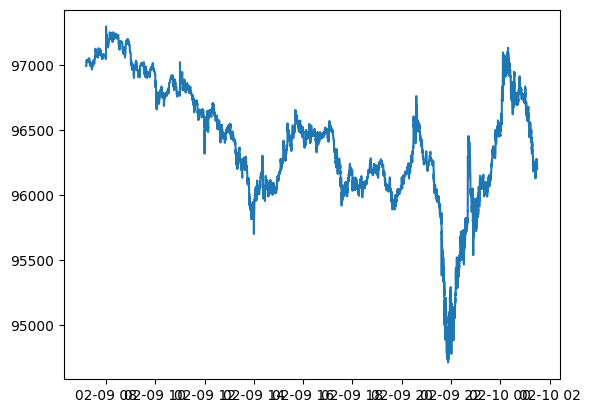

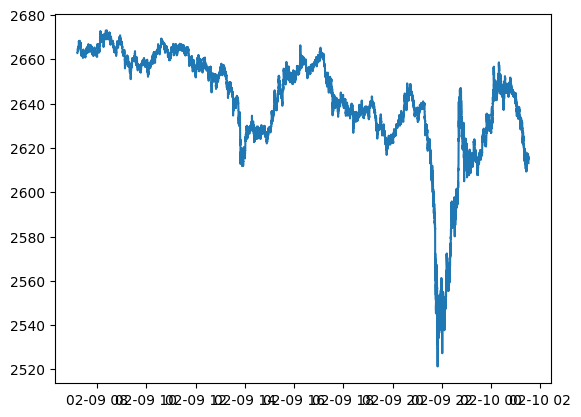

In [419]:
plt.plot(data['REFPRICE']['BTCUSDT'] * TICK_SIZES['BTCUSDT'])
plt.show()
plt.plot(data['REFPRICE']['ETHUSDT'] * TICK_SIZES['ETHUSDT'])
plt.show()

In [420]:
data['REFPRICE']['BTCUSDT']

timestamp
2025-02-09 07:12:01.814    9698999.5
2025-02-09 07:12:01.914    9698999.5
2025-02-09 07:12:02.014    9698999.5
2025-02-09 07:12:02.114    9698999.5
2025-02-09 07:12:02.214    9698999.5
                             ...    
2025-02-10 01:29:51.014    9620000.5
2025-02-10 01:29:51.114    9620000.5
2025-02-10 01:29:51.214    9620000.5
2025-02-10 01:29:51.314    9620000.5
2025-02-10 01:29:51.414    9620000.5
Length: 655977, dtype: float64

In [421]:
data['DEPTH']['BTCUSDT']

,bp1,bp2,bp3,bp4,bp5,bp6,bp7,bp8,bp9,bp10,bv1,bv2,bv3,bv4,bv5,bv6,bv7,bv8,bv9,bv10,ap1,ap2,ap3,ap4,ap5,ap6,ap7,ap8,ap9,ap10,av1,av2,av3,av4,av5,av6,av7,av8,av9,av10
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-02-09 07:12:01.814,-1,-2,-3,-4,-9,-10,-19,-20,-21,-22,1148072,18,18,18,29,5861,29,73024,12,12,1,31,44,47,48,67,77,85,134,135,2050288,28,18,29,18,18,18,18,24,1056
2025-02-09 07:12:01.914,-1,-2,-3,-4,-9,-10,-19,-20,-21,-22,1148072,18,18,18,29,5861,29,73024,12,12,1,31,44,47,48,67,77,85,134,135,2050288,28,18,29,18,18,18,18,24,1056
2025-02-09 07:12:02.014,-1,-2,-3,-4,-9,-10,-19,-20,-21,-22,1148072,18,18,18,29,5861,29,73024,12,12,1,31,44,47,48,67,77,85,134,135,2050288,28,18,29,18,18,18,18,24,1056
2025-02-09 07:12:02.114,-1,-2,-3,-4,-9,-10,-19,-20,-21,-22,1147977,18,18,18,29,5861,29,73024,12,12,1,31,44,47,48,67,77,85,134,135,2048261,28,18,29,18,18,18,18,24,1056
2025-02-09 07:12:02.214,-1,-2,-3,-4,-9,-10,-19,-20,-21,-22,1147893,18,18,18,29,5861,29,73024,12,12,1,31,44,47,48,67,77,85,134,135,2048272,28,18,18,18,18,18,18,24,1056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-10 01:29:51.014,-1,-8,-73,-79,-125,-126,-141,-180,-200,-201,1035129,36,28,25,18,18,18,28,24,7151,1,35,36,37,38,56,79,112,115,153,621713,18,24374,7359,6,6,12,772,6144,6
2025-02-10 01:29:51.114,-1,-8,-73,-79,-125,-126,-141,-180,-200,-201,1035129,36,28,25,18,18,18,28,24,7151,1,35,36,37,38,56,79,112,115,153,621720,18,24374,7359,6,6,12,772,6144,6
2025-02-10 01:29:51.214,-1,-8,-73,-79,-125,-126,-141,-180,-200,-201,1035129,36,28,25,18,18,18,28,24,7151,1,35,36,37,38,56,79,112,115,153,621720,18,24374,7359,6,6,12,760,6083,6


In [422]:
data['TRADE']['BTCUSDT']

,p,q,mm_buy
timestamp,,,
2025-02-09 07:12:02.067,1,14,0
2025-02-09 07:12:02.069,1,1999,0
2025-02-09 07:12:02.071,-1,96,1
2025-02-09 07:12:02.464,1,1374,0
2025-02-09 07:12:03.252,1,289,0
...,...,...,...
2025-02-10 01:29:48.730,1,1642,0
2025-02-10 01:29:49.639,-1,28,1
2025-02-10 01:29:49.970,1,6,0


In [423]:
data['DEPTH']['BTCUSDT'].loc[:, 'bv1':'bv10']

,bv1,bv2,bv3,bv4,bv5,bv6,bv7,bv8,bv9,bv10
timestamp,,,,,,,,,,
2025-02-09 07:12:01.814,1148072,18,18,18,29,5861,29,73024,12,12
2025-02-09 07:12:01.914,1148072,18,18,18,29,5861,29,73024,12,12
2025-02-09 07:12:02.014,1148072,18,18,18,29,5861,29,73024,12,12
2025-02-09 07:12:02.114,1147977,18,18,18,29,5861,29,73024,12,12
2025-02-09 07:12:02.214,1147893,18,18,18,29,5861,29,73024,12,12
...,...,...,...,...,...,...,...,...,...,...
2025-02-10 01:29:51.014,1035129,36,28,25,18,18,18,28,24,7151
2025-02-10 01:29:51.114,1035129,36,28,25,18,18,18,28,24,7151
2025-02-10 01:29:51.214,1035129,36,28,25,18,18,18,28,24,7151


In [424]:
data['DEPTH']['BTCUSDT'].loc[:, [f'bp{i}' for i in range(10, 0, -1)] + [f'ap{i}' for i in range(1, 11)]].head(100)

,bp10,bp9,bp8,bp7,bp6,bp5,bp4,bp3,bp2,bp1,ap1,ap2,ap3,ap4,ap5,ap6,ap7,ap8,ap9,ap10
timestamp,,,,,,,,,,,,,,,,,,,,
2025-02-09 07:12:01.814,-22,-21,-20,-19,-10,-9,-4,-3,-2,-1,1,31,44,47,48,67,77,85,134,135
2025-02-09 07:12:01.914,-22,-21,-20,-19,-10,-9,-4,-3,-2,-1,1,31,44,47,48,67,77,85,134,135
2025-02-09 07:12:02.014,-22,-21,-20,-19,-10,-9,-4,-3,-2,-1,1,31,44,47,48,67,77,85,134,135
2025-02-09 07:12:02.114,-22,-21,-20,-19,-10,-9,-4,-3,-2,-1,1,31,44,47,48,67,77,85,134,135
2025-02-09 07:12:02.214,-22,-21,-20,-19,-10,-9,-4,-3,-2,-1,1,31,44,47,48,67,77,85,134,135
2025-02-09 07:12:02.314,-22,-21,-20,-19,-10,-9,-4,-3,-2,-1,1,31,44,47,48,67,77,85,134,135
2025-02-09 07:12:02.414,-22,-21,-20,-19,-10,-9,-4,-3,-2,-1,1,31,44,47,48,67,77,85,134,135
2025-02-09 07:12:02.514,-22,-21,-20,-19,-10,-9,-4,-3,-2,-1,1,31,44,47,48,67,77,85,134,135
2025-02-09 07:12:02.614,-22,-21,-20,-19,-10,-9,-4,-3,-2,-1,1,23,31,44,47,48,67,77,85,134


In [425]:
data['REFPRICE']['BTCUSDT'].head(100)

timestamp
2025-02-09 07:12:01.814    9698999.5
2025-02-09 07:12:01.914    9698999.5
2025-02-09 07:12:02.014    9698999.5
2025-02-09 07:12:02.114    9698999.5
2025-02-09 07:12:02.214    9698999.5
2025-02-09 07:12:02.314    9698999.5
2025-02-09 07:12:02.414    9698999.5
2025-02-09 07:12:02.514    9698999.5
2025-02-09 07:12:02.614    9698999.5
2025-02-09 07:12:02.714    9698999.5
2025-02-09 07:12:02.814    9698999.5
2025-02-09 07:12:02.914    9698999.5
2025-02-09 07:12:03.014    9698999.5
2025-02-09 07:12:03.114    9698999.5
2025-02-09 07:12:03.214    9698999.5
2025-02-09 07:12:03.314    9698999.5
2025-02-09 07:12:03.414    9698999.5
2025-02-09 07:12:03.514    9698999.5
2025-02-09 07:12:03.614    9698999.5
2025-02-09 07:12:03.714    9698999.5
2025-02-09 07:12:03.814    9698999.5
2025-02-09 07:12:03.914    9698999.5
2025-02-09 07:12:04.014    9698999.5
2025-02-09 07:12:04.114    9698999.5
2025-02-09 07:12:04.214    9698999.5
2025-02-09 07:12:04.314    9698999.5
2025-02-09 07:12:04.414    9

In [426]:
data['TRADE']['BTCUSDT'].query('p==0')

,p,q,mm_buy
timestamp,,,
2025-02-09 08:13:25.954,0,21,0
2025-02-09 08:55:03.662,0,6,0
2025-02-09 10:08:13.008,0,374,0
2025-02-09 10:19:08.710,0,103,0
2025-02-09 10:49:01.388,0,6,0
...,...,...,...
2025-02-10 00:05:22.385,0,93,0
2025-02-10 00:06:43.094,0,100,0
2025-02-10 00:19:47.906,0,6,0


In [427]:
data['TRADE']['BTCUSDT'].head(100)

,p,q,mm_buy
timestamp,,,
2025-02-09 07:12:02.067,1,14,0
2025-02-09 07:12:02.069,1,1999,0
2025-02-09 07:12:02.071,-1,96,1
2025-02-09 07:12:02.464,1,1374,0
2025-02-09 07:12:03.252,1,289,0
2025-02-09 07:12:03.255,1,1999,0
2025-02-09 07:12:03.373,1,508,0
2025-02-09 07:12:03.751,1,369,0
2025-02-09 07:12:03.758,1,220,0


In [428]:
data['DEPTH']['BTCUSDT'].loc[:, [f'bv{i}' for i in range(10, 0, -1)] + [f'av{i}' for i in range(1, 11)]].head(100)

,bv10,bv9,bv8,bv7,bv6,bv5,bv4,bv3,bv2,bv1,av1,av2,av3,av4,av5,av6,av7,av8,av9,av10
timestamp,,,,,,,,,,,,,,,,,,,,
2025-02-09 07:12:01.814,12,12,73024,29,5861,29,18,18,18,1148072,2050288,28,18,29,18,18,18,18,24,1056
2025-02-09 07:12:01.914,12,12,73024,29,5861,29,18,18,18,1148072,2050288,28,18,29,18,18,18,18,24,1056
2025-02-09 07:12:02.014,12,12,73024,29,5861,29,18,18,18,1148072,2050288,28,18,29,18,18,18,18,24,1056
2025-02-09 07:12:02.114,12,12,73024,29,5861,29,18,18,18,1147977,2048261,28,18,29,18,18,18,18,24,1056
2025-02-09 07:12:02.214,12,12,73024,29,5861,29,18,18,18,1147893,2048272,28,18,18,18,18,18,18,24,1056
2025-02-09 07:12:02.314,12,12,73024,29,5861,29,18,18,18,1147978,2048272,28,18,18,18,18,18,18,24,1056
2025-02-09 07:12:02.414,12,12,73024,29,5861,29,18,18,18,1147978,2048261,28,18,18,18,18,18,18,24,1056
2025-02-09 07:12:02.514,12,12,73024,29,5861,29,18,18,18,1145327,2046886,28,18,18,18,18,18,18,24,1056
2025-02-09 07:12:02.614,12,12,73024,29,5861,29,18,18,18,1147979,2046911,29,28,18,18,18,18,18,12,24


In [429]:
data['DEPTH']['BTCUSDT']

,bp1,bp2,bp3,bp4,bp5,bp6,bp7,bp8,bp9,bp10,bv1,bv2,bv3,bv4,bv5,bv6,bv7,bv8,bv9,bv10,ap1,ap2,ap3,ap4,ap5,ap6,ap7,ap8,ap9,ap10,av1,av2,av3,av4,av5,av6,av7,av8,av9,av10
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-02-09 07:12:01.814,-1,-2,-3,-4,-9,-10,-19,-20,-21,-22,1148072,18,18,18,29,5861,29,73024,12,12,1,31,44,47,48,67,77,85,134,135,2050288,28,18,29,18,18,18,18,24,1056
2025-02-09 07:12:01.914,-1,-2,-3,-4,-9,-10,-19,-20,-21,-22,1148072,18,18,18,29,5861,29,73024,12,12,1,31,44,47,48,67,77,85,134,135,2050288,28,18,29,18,18,18,18,24,1056
2025-02-09 07:12:02.014,-1,-2,-3,-4,-9,-10,-19,-20,-21,-22,1148072,18,18,18,29,5861,29,73024,12,12,1,31,44,47,48,67,77,85,134,135,2050288,28,18,29,18,18,18,18,24,1056
2025-02-09 07:12:02.114,-1,-2,-3,-4,-9,-10,-19,-20,-21,-22,1147977,18,18,18,29,5861,29,73024,12,12,1,31,44,47,48,67,77,85,134,135,2048261,28,18,29,18,18,18,18,24,1056
2025-02-09 07:12:02.214,-1,-2,-3,-4,-9,-10,-19,-20,-21,-22,1147893,18,18,18,29,5861,29,73024,12,12,1,31,44,47,48,67,77,85,134,135,2048272,28,18,18,18,18,18,18,24,1056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-10 01:29:51.014,-1,-8,-73,-79,-125,-126,-141,-180,-200,-201,1035129,36,28,25,18,18,18,28,24,7151,1,35,36,37,38,56,79,112,115,153,621713,18,24374,7359,6,6,12,772,6144,6
2025-02-10 01:29:51.114,-1,-8,-73,-79,-125,-126,-141,-180,-200,-201,1035129,36,28,25,18,18,18,28,24,7151,1,35,36,37,38,56,79,112,115,153,621720,18,24374,7359,6,6,12,772,6144,6
2025-02-10 01:29:51.214,-1,-8,-73,-79,-125,-126,-141,-180,-200,-201,1035129,36,28,25,18,18,18,28,24,7151,1,35,36,37,38,56,79,112,115,153,621720,18,24374,7359,6,6,12,760,6083,6


In [430]:
data['DEPTH']['BTCUSDT'].iloc[0:3, :]

,bp1,bp2,bp3,bp4,bp5,bp6,bp7,bp8,bp9,bp10,bv1,bv2,bv3,bv4,bv5,bv6,bv7,bv8,bv9,bv10,ap1,ap2,ap3,ap4,ap5,ap6,ap7,ap8,ap9,ap10,av1,av2,av3,av4,av5,av6,av7,av8,av9,av10
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-02-09 07:12:01.814,-1,-2,-3,-4,-9,-10,-19,-20,-21,-22,1148072,18,18,18,29,5861,29,73024,12,12,1,31,44,47,48,67,77,85,134,135,2050288,28,18,29,18,18,18,18,24,1056
2025-02-09 07:12:01.914,-1,-2,-3,-4,-9,-10,-19,-20,-21,-22,1148072,18,18,18,29,5861,29,73024,12,12,1,31,44,47,48,67,77,85,134,135,2050288,28,18,29,18,18,18,18,24,1056
2025-02-09 07:12:02.014,-1,-2,-3,-4,-9,-10,-19,-20,-21,-22,1148072,18,18,18,29,5861,29,73024,12,12,1,31,44,47,48,67,77,85,134,135,2050288,28,18,29,18,18,18,18,24,1056


In [431]:
odb_dict = data['DEPTH']['BTCUSDT'].to_dict(orient='records')
odb_tup_keys = [(f'bp{i}', f'bv{i}') for i in range(10, 0, -1)] + [(f'ap{i}', f'av{i}') for i in range(1, 11)]
for i in tqdm(range(len(odb_dict))):
    odb_dict[i] = { odb_dict[i][p]: odb_dict[i][q] for p, q in odb_tup_keys }
    odb_dict[i]['t'] = data['DEPTH']['BTCUSDT'].index[i]

100%|██████████| 655977/655977 [00:03<00:00, 190487.26it/s]


In [432]:
trade_dict = data['TRADE']['BTCUSDT'].to_dict(orient='records')
for i in tqdm(range(len(trade_dict))):
    trade_dict[i] = { trade_dict[i]['p']: trade_dict[i]['q'] }
    trade_dict[i]['t'] = data['TRADE']['BTCUSDT'].index[i]

100%|██████████| 2107422/2107422 [00:08<00:00, 261702.67it/s]


In [433]:
odb_dict[0]

{-22: 12,
 -21: 12,
 -20: 73024,
 -19: 29,
 -10: 5861,
 -9: 29,
 -4: 18,
 -3: 18,
 -2: 18,
 -1: 1148072,
 1: 2050288,
 31: 28,
 44: 18,
 47: 29,
 48: 18,
 67: 18,
 77: 18,
 85: 18,
 134: 24,
 135: 1056,
 't': Timestamp('2025-02-09 07:12:01.814000')}

In [434]:
trade_dict[0]

{1: 14, 't': Timestamp('2025-02-09 07:12:02.067000')}

In [254]:
odb_ptr, trade_ptr = 0, 0
for _ in range(200):
    if odb_dict[odb_ptr]['t'] <= trade_dict[trade_ptr]['t']:
        print(odb_dict[odb_ptr])
        odb_ptr += 1
    else:
        print(trade_dict[trade_ptr])
        trade_ptr += 1

{-107: 54381, -97: 5142, -96: 7699, -95: 18, -62: 6, -33: 6, -31: 6, -16: 4646, -15: 18, -1: 78781, 1: 983, 42: 24, 43: 829, 129: 24, 130: 2157, 132: 24, 133: 2257, 143: 1230, 174: 865, 185: 721, 't': Timestamp('2025-02-02 23:02:30.748648+0000', tz='UTC')}
{-1: 80, 't': Timestamp('2025-02-02 23:02:30.803468+0000', tz='UTC')}
{-107: 54381, -97: 5142, -96: 7699, -95: 18, -62: 6, -33: 6, -31: 6, -16: 4646, -15: 18, -1: 78847, 1: 983, 29: 18, 42: 24, 43: 829, 129: 24, 130: 2157, 132: 24, 133: 2257, 143: 1230, 174: 865, 't': Timestamp('2025-02-02 23:02:30.803498+0000', tz='UTC')}
{-107: 33013, -97: 5142, -96: 18, -95: 6, -62: 6, -33: 6, -31: 6, -16: 4646, -15: 18, -1: 81618, 1: 983, 29: 12, 42: 24, 43: 829, 129: 24, 130: 2157, 132: 24, 133: 2257, 143: 1230, 174: 865, 't': Timestamp('2025-02-02 23:02:30.845699+0000', tz='UTC')}
{-1: 10, 't': Timestamp('2025-02-02 23:02:30.867129+0000', tz='UTC')}
{-1: 11, 't': Timestamp('2025-02-02 23:02:30.890064+0000', tz='UTC')}
{1: 952, 't': Timestamp('2

In [435]:
odb_ptr, trade_ptr = 0, 0
prev_ref_price, curr_ref_price = 0, 0
temp_odb = dict()
temp_limits = dict()

for _ in range(1000):

    if odb_dict[odb_ptr]['t'] <= trade_dict[trade_ptr]['t']:

        print('------------- LIMIT ORDERBOOK SNAPSHOT -------------')
        # print the current limit orderbook snapshot
        print('Current Orderbook State:')
        print(odb_dict[odb_ptr])

        # get the current reference price
        curr_ref_price = data['REFPRICE']['BTCUSDT'].iloc[odb_ptr]

        # if the current reference price is different from the previous reference price we reset the setup
        if curr_ref_price != prev_ref_price:
            print(f'Reference Price Changed: {prev_ref_price} --> {curr_ref_price}')
            print(f'All Queues are assumed to be newly initialized!')

        else:
            print('Orderbook State Just Before This Snapshot:')
            print(temp_odb)

        temp_odb = copy.deepcopy(odb_dict[odb_ptr])
        temp_limits = dict()
        prev_ref_price = curr_ref_price
        odb_ptr += 1
        print('----------------------------------------------------')

    else:
        # print the current trade
        print(trade_dict[trade_ptr])
        
        # get the price and quantity from the trade
        for p, q in trade_dict[trade_ptr].items():

            # do not process the timestamp key-val
            if p != 't':

                # get the sign of the trade from MM perspective -1 implies MM buy and 1 implies MM sell
                sign = int(p/abs(p))

                # Check if there are any non-empty price levels closer to the reference price compared to the trade price
                for price in range(sign, p, sign):
                    # if there is
                    if temp_odb.get(price, 0):
                        # it means that level was not present when this trade happened or in other words it was cancelled
                        print(f'Limit at {price} was cancelled before this trade. The quantity present there was >= {temp_odb.get(price, 0)}')
                        # delete this level
                        del temp_odb[price]

                # if the price is present in the temp_orderbook we are maintaining
                if p in temp_odb:
                    
                    # If there is nothing closer than the traded price to the reference price check if the quantity traded at this price is possible
                    # o.w. it will mean new limit orders were added at this price level before this trade occured
                    if temp_odb[p] < q:
                        print(f'New Limit Orders were added to {p} before this trade with agg quantity >= {q-temp_odb[p]}')
                        # Add this to the temp_limits dictionary to keep track of this inferred new limit order from this trade
                        temp_limits[p] = temp_limits.get(p, 0) + q - temp_odb[p]
                    else:
                        # the quantity of the trade is possible and hence we can not infer whether some limit order was added or not
                        temp_odb[p] -= q

                        # if all the quantity at this price level is exhausted remove the level
                        if temp_odb[p] == 0:
                            del temp_odb[p]

                # if the price is not present in the temp_orderbook we are maintaining
                else:

                    # This means that there is had been new limit orders waiting in the orderbook when the trade occurred
                    # Check if we have already accounted for this new trade
                    if p in temp_limits:
                        # if we have done so, then we can now say that the agg quantity at this new level was more than what we inferred before
                        temp_limits[p] += q
                        print(f'New Limit Order Info Updated at {p}, agg quantity >= {temp_limits[p]}')
                    else:
                        # o.w. we have info that there are new limit orders at this new level with agg quantity at least that of the trade
                        temp_limits[p] = q
                        print(f'New Limit Orders Inserted at {p} before this trade with aggregated quantity >= {temp_limits[p]}')

        trade_ptr += 1



------------- LIMIT ORDERBOOK SNAPSHOT -------------
Current Orderbook State:
{-22: 12, -21: 12, -20: 73024, -19: 29, -10: 5861, -9: 29, -4: 18, -3: 18, -2: 18, -1: 1148072, 1: 2050288, 31: 28, 44: 18, 47: 29, 48: 18, 67: 18, 77: 18, 85: 18, 134: 24, 135: 1056, 't': Timestamp('2025-02-09 07:12:01.814000')}
Reference Price Changed: 0 --> 9698999.5
All Queues are assumed to be newly initialized!
----------------------------------------------------
------------- LIMIT ORDERBOOK SNAPSHOT -------------
Current Orderbook State:
{-22: 12, -21: 12, -20: 73024, -19: 29, -10: 5861, -9: 29, -4: 18, -3: 18, -2: 18, -1: 1148072, 1: 2050288, 31: 28, 44: 18, 47: 29, 48: 18, 67: 18, 77: 18, 85: 18, 134: 24, 135: 1056, 't': Timestamp('2025-02-09 07:12:01.914000')}
Orderbook State Just Before This Snapshot:
{-22: 12, -21: 12, -20: 73024, -19: 29, -10: 5861, -9: 29, -4: 18, -3: 18, -2: 18, -1: 1148072, 1: 2050288, 31: 28, 44: 18, 47: 29, 48: 18, 67: 18, 77: 18, 85: 18, 134: 24, 135: 1056, 't': Timestamp(

In [384]:
data['TRADE']['BTCUSDT'].query('p >= 0 & mm_buy == 1')

,p,q,mm_buy
timestamp,,,
2025-02-09 07:12:10.708,199,32,1
2025-02-09 07:12:10.797,863,89,1
2025-02-09 07:12:10.798,863,89,1
2025-02-09 07:12:10.807,863,89,1
2025-02-09 07:12:22.112,403,56,1
...,...,...,...
2025-02-10 01:28:02.395,79,27,1
2025-02-10 01:28:03.971,147,76,1
2025-02-10 01:28:05.402,303,11,1


In [212]:
data['DEPTH']['BTCUSDT'].to_dict(orient='records')[0]

{'bp1': -1,
 'bp2': -15,
 'bp3': -16,
 'bp4': -31,
 'bp5': -33,
 'bp6': -62,
 'bp7': -95,
 'bp8': -96,
 'bp9': -97,
 'bp10': -107,
 'bv1': 78781,
 'bv2': 18,
 'bv3': 4646,
 'bv4': 6,
 'bv5': 6,
 'bv6': 6,
 'bv7': 18,
 'bv8': 7699,
 'bv9': 5142,
 'bv10': 54381,
 'ap1': 1,
 'ap2': 42,
 'ap3': 43,
 'ap4': 129,
 'ap5': 130,
 'ap6': 132,
 'ap7': 133,
 'ap8': 143,
 'ap9': 174,
 'ap10': 185,
 'av1': 983,
 'av2': 24,
 'av3': 829,
 'av4': 24,
 'av5': 2157,
 'av6': 24,
 'av7': 2257,
 'av8': 1230,
 'av9': 865,
 'av10': 721}

In [159]:
data['REFPRICE']['BTCUSDT'].diff().value_counts().head(100)

 0.0       97512
-1.0         624
 1.0         429
-200.0       299
-400.0       266
 400.0       231
 200.0       205
-2.0         187
-199.0       166
 2.0         136
-600.0       117
 600.0       107
-800.0       106
 199.0       105
 800.0       104
-399.0       101
 399.0        99
-599.0        92
-201.0        91
-401.0        85
-198.0        75
 599.0        75
 9.0          75
 201.0        75
-799.0        74
-398.0        72
-9.0          71
 401.0        69
-3.0          68
 198.0        68
-601.0        65
-8.0          63
-598.0        61
-40.0         59
 799.0        59
-38.0         59
 1000.0       59
-50.0         56
-640.0        56
-7.0          56
-94.0         56
 7.0          56
-4.0          56
-45.0         55
-197.0        55
-79.0         55
-999.0        55
 10.0         54
 598.0        54
 398.0        53
-1000.0       53
-24.0         52
-100.0        52
-80.0         52
 3.0          51
 640.0        51
-149.0        51
-34.0         51
-51.0         

In [199]:
data['TRADE']['BTCUSDT'].groupby('p').mean().query('p == -1')

,q,mm_buy
p,,
-1,1094.006121,0.996309
